In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

2024-06-10 10:55:40.870636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 10:55:40.870736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 10:55:41.032218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path='/kaggle/input/realifake/Realifake'

In [3]:
def projection_block(x, filters, strides,padding='same'):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides,padding='same')
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1),padding='same')
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1),padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides,padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [4]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [5]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [6]:
def ResNet34(shape = (300, 300, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
     # Step 4 End Dense Network
         # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model
      

In [7]:
batch_size =256
img_height = 300
img_width = 300

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 174425 files belonging to 2 classes.
Using 104655 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 174425 files belonging to 2 classes.
Using 69770 files for validation.


In [10]:
# Check class names
class_names = train_ds.class_names
print(class_names)

['FAKE', 'REAL']


In [11]:
test_ds = val_ds.take(int(len(val_ds) * 0.5))
val_ds = val_ds.skip(int(len(val_ds) * 0.5))

In [12]:
model= ResNet34()

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])

In [14]:
epochs = 28
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/28


2024-06-10 11:02:16.163256: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,301,301]{3,2,1,0}, f32[256,64,153,153]{3,2,1,0}), window={size=7x7 stride=2x2 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-10 11:02:22.053983: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.890903373s
Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,301,301]{3,2,1,0}, f32[256,64,153,153]{3,2,1,0}), window={size=7x7 stride=2x2 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-10 11:02:

408/409 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5697 - loss: 2.5148

2024-06-10 11:20:49.751447: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[207,3,301,301]{3,2,1,0}, f32[207,64,153,153]{3,2,1,0}), window={size=7x7 stride=2x2 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-10 11:20:55.101066: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.349796444s
Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[207,3,301,301]{3,2,1,0}, f32[207,64,153,153]{3,2,1,0}), window={size=7x7 stride=2x2 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-10 11:20:

409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5698 - loss: 2.5110

W0000 00:00:1718018569.397062      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718018711.812674      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


409/409 ━━━━━━━━━━━━━━━━━━━━ 1465s 3s/step - accuracy: 0.5700 - loss: 2.5072 - val_accuracy: 0.7031 - val_loss: 0.5771
Epoch 2/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1158s 3s/step - accuracy: 0.8239 - loss: 0.3674 - val_accuracy: 0.8169 - val_loss: 0.3987
Epoch 3/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1165s 3s/step - accuracy: 0.8992 - loss: 0.2202 - val_accuracy: 0.8693 - val_loss: 0.2879
Epoch 4/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1164s 3s/step - accuracy: 0.9180 - loss: 0.1809 - val_accuracy: 0.7939 - val_loss: 0.4151
Epoch 5/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1163s 3s/step - accuracy: 0.9274 - loss: 0.1591 - val_accuracy: 0.8292 - val_loss: 0.3729
Epoch 6/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1223s 3s/step - accuracy: 0.9333 - loss: 0.1445 - val_accuracy: 0.8929 - val_loss: 0.2235
Epoch 7/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1221s 3s/step - accuracy: 0.9397 - loss: 0.1316 - val_accuracy: 0.8989 - val_loss: 0.2583
Epoch 8/28
409/409 ━━━━━━━━━━━━━━━━━━━━ 1222s 3s/step - accuracy: 0.9466 - loss: 0.1177 - val_accurac

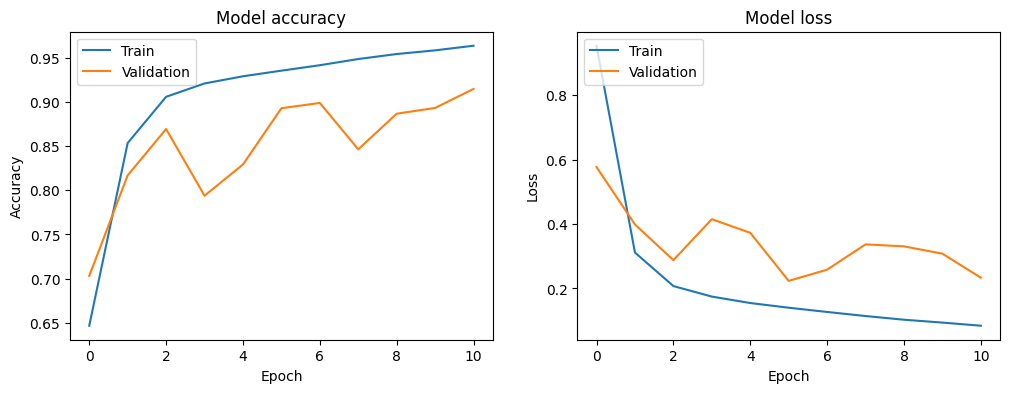

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()